<a href="https://colab.research.google.com/github/ravijp/Deep-Learning-Papers-Reading-Roadmap/blob/master/Trying%20out%20different%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ravijp/JBMClassification.git

Cloning into 'JBMClassification'...
remote: Enumerating objects: 274, done.
remote: Total 274 (delta 0), reused 0 (delta 0), pack-reused 274
Receiving objects: 100% (274/274), 871.18 MiB | 40.59 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (256/256), done.


In [2]:
import glob
from random import shuffle
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import optimizers
%matplotlib inline

W0417 15:14:49.319502 140330951157632 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
# image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/2')
feature_extractor_url  = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/2'

def feature_extractor(x):
  feature_extractor_module  = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

display(print(f'Image size for hub module is {IMAGE_SIZE}'))

Instructions for updating:
Colocations handled automatically by placer.


W0417 15:14:51.457925 140330951157632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Image size for hub module is [224, 224]


None

Import data in generator format

In [0]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False

## Import data in generators

In [0]:
def getLabel(filePaths):
	labels = []
	for img in filePaths:
		if 'Healthy' in img:
			labels.append(0)
		elif 'defects' in img:
			labels.append(1)

	dataZip = list(zip(filePaths, labels))
	shuffle(dataZip)
	filePaths, labels = zip(*dataZip)
	return filePaths, labels


def split_trainTest(imgsAll, labelAll, splitRatio = 0.20):
	dataZip = list(zip(imgsAll, labelAll))
	shuffle(dataZip)
	imgsAll, labelAll = zip(*dataZip)
	splitPoint = int(len(imgsAll)*splitRatio)

	trainImgs = imgsAll[:int(len(imgsAll) - splitPoint)]
	trainLabel = labelAll[:int(len(imgsAll) - splitPoint)]
	testImgs = imgsAll[int(len(imgsAll)-splitPoint):]
	testLabel = labelAll[int(len(imgsAll)-splitPoint):]

	return trainImgs, testImgs, trainLabel, testLabel

images, labels = getLabel(glob.glob('/content/JBMClassification/*/*.jpg'))
# split the images into train and test sets.
X_train, X_test, y_train, y_test = split_trainTest(images, labels,  splitRatio=0.25)

In [6]:
display(print(f'SHape of training dataset {len(X_train)} and shape of validation set is {len(X_test)}'))

train_imgs = [img_to_array(load_img(img, target_size=IMAGE_SIZE)) for img in X_train]
train_imgs = np.array(train_imgs)
train_labels = list(y_train)
validation_imgs = [img_to_array(load_img(img, target_size=IMAGE_SIZE)) for img in X_test]
validation_imgs = np.array(validation_imgs)
validation_labels = list(y_test)

SHape of training dataset 188 and shape of validation set is 62


None

In [7]:
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

Train dataset shape: (188, 224, 224, 3) 	Validation dataset shape: (62, 224, 224, 3)


In [0]:
batch_size = 32
num_classes = 2
epochs = 30
input_shape = (224, 224, 3)
img_width, img_height = 224, 224

In [0]:
from keras import backend as K

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

In [0]:
history = model.fit(x=train_imgs_scaled, y=train_labels,
                    validation_data=(validation_imgs_scaled, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

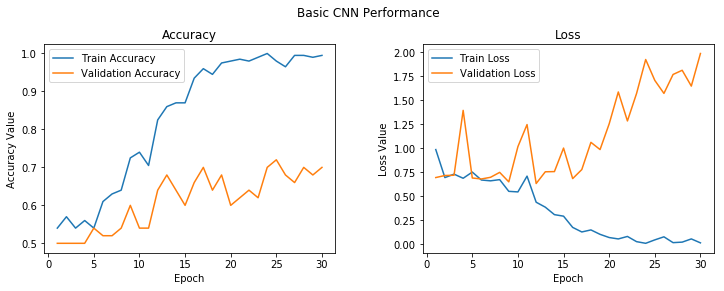

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Model with **Image Augmentation**

In [0]:
# train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
#                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
#                                    horizontal_flip=True, fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs_scaled, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs_scaled, validation_labels, batch_size=batch_size//2)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0417 15:15:48.981417 140330951157632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
__________

In [11]:
history = model.fit_generator(train_generator, epochs=100,
                              validation_data=val_generator,
                              verbose=1)           

Instructions for updating:
Use tf.cast instead.


W0417 15:16:13.987370 140330951157632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/100
6/6 [==============================] - 22s 4s/step - loss: 0.6910 - acc: 0.5691 - val_loss: 0.6909 - val_acc: 0.5645
Epoch 2/100
6/6 [==============================] - 20s 3s/step - loss: 0.6942 - acc: 0.4947 - val_loss: 0.6895 - val_acc: 0.5645
Epoch 3/100
6/6 [==============================] - 20s 3s/step - loss: 0.6932 - acc: 0.5266 - val_loss: 0.6865 - val_acc: 0.5645
Epoch 4/100
6/6 [==============================] - 19s 3s/step - loss: 0.6934 - acc: 0.5479 - val_loss: 0.6883 - val_acc: 0.5645
Epoch 5/100
6/6 [==============================] - 20s 3s/step - loss: 0.6897 - acc: 0.5479 - val_loss: 0.6862 - val_acc: 0.5645
Epoch 6/100
6/6 [==============================] - 20s 3s/step - loss: 0.6934 - acc: 0.5479 - val_loss: 0.6878 - val_acc: 0.5645
Epoch 7/100
6/6 [==============================] - 20s 3s/step - loss: 0.6926 - acc: 0.5479 - val_loss: 0.6884 - val_acc: 0.5645
Epoch 8/100
6/6 [==============================] - 19s 3s/step - loss: 0.6907 - acc: 0.5532 - val

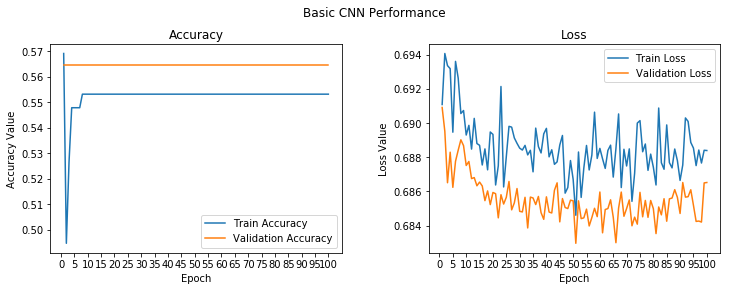

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cnn_img_aug.h5')

# Transfer learning

### Pre-trained CNN model as a Feature Extractor with Image Augmentation

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras
from keras.applications.inception_v3 import InceptionV3
# vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
#                                      input_shape=input_shape)

vgg = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f6ed2519898>,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0x7f6ed2514320>,conv2d_96,False
2,<keras.layers.normalization.BatchNormalization object at 0x7f6ed2519a90>,batch_normalization_95,False
3,<keras.layers.core.Activation object at 0x7f6ed2517438>,activation_95,False
4,<keras.layers.convolutional.Conv2D object at 0x7f6ed24d1f60>,conv2d_97,False
5,<keras.layers.normalization.BatchNormalization object at 0x7f6ed24b7e80>,batch_normalization_96,False
6,<keras.layers.core.Activation object at 0x7f6ed2475d68>,activation_96,False
7,<keras.layers.convolutional.Conv2D object at 0x7f6ed2408588>,conv2d_98,False
8,<keras.layers.normalization.BatchNormalization object at 0x7f6ed2379710>,batch_normalization_97,False
9,<keras.layers.core.Activation object at 0x7f6ed23316d8>,activation_97,False


In [0]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (188, 51200) 	Validation Bottleneck Features: (62, 51200)


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total para

In [0]:
history = model.fit(x=train_features_vgg, y=train_labels,
                    validation_data=(validation_features_vgg, validation_labels),
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1)

Train on 188 samples, validate on 62 samples
Epoch 1/100
188/188 [==============================] - 8s 41ms/step - loss: 0.9185 - acc: 0.5638 - val_loss: 0.7001 - val_acc: 0.5484
Epoch 2/100
188/188 [==============================] - 2s 11ms/step - loss: 0.8254 - acc: 0.5266 - val_loss: 0.7018 - val_acc: 0.5645
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.6356 - acc: 0.6383 - val_loss: 0.6959 - val_acc: 0.5645
Epoch 4/100
188/188 [==============================] - 2s 11ms/step - loss: 0.6424 - acc: 0.6702 - val_loss: 0.6119 - val_acc: 0.5968
Epoch 5/100
188/188 [==============================] - 2s 11ms/step - loss: 0.6303 - acc: 0.6702 - val_loss: 0.6351 - val_acc: 0.5645
Epoch 6/100
188/188 [==============================] - 2s 11ms/step - loss: 0.6181 - acc: 0.7021 - val_loss: 0.5865 - val_acc: 0.6290
Epoch 7/100
188/188 [==============================] - 2s 11ms/step - loss: 0.6055 - acc: 0.6915 - val_loss: 0.6141 - val_acc: 0.5968
Epoch 8/100
188/1

In [0]:
model.save('tlearn_basic_cnn_inception_9.h5')

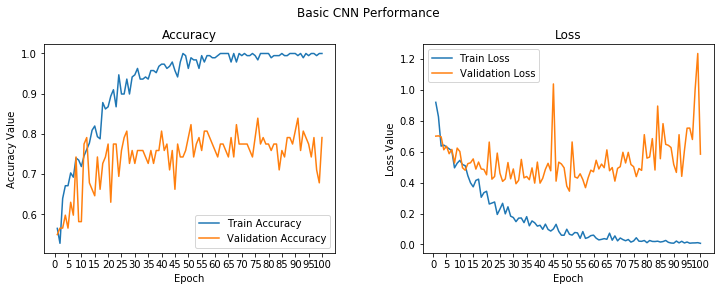

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#### Pre-trained CNN model as a Feature Extractor with Image Augmentation

In [0]:

train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs_scaled, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs_scaled, validation_labels, batch_size=batch_size//2)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['accuracy'])

In [0]:
 
history = model.fit_generator(train_generator, epochs=100, steps_per_epoch=20,
                              validation_data=val_generator, validation_steps=5,
                              verbose=1)    

Epoch 1/100
20/20 [==============================] - 141s 7s/step - loss: 0.9214 - acc: 0.5500 - val_loss: 0.6776 - val_acc: 0.6000
Epoch 2/100
20/20 [==============================] - 135s 7s/step - loss: 0.7995 - acc: 0.4900 - val_loss: 0.7918 - val_acc: 0.5600
Epoch 3/100
20/20 [==============================] - 133s 7s/step - loss: 0.7715 - acc: 0.5300 - val_loss: 0.7092 - val_acc: 0.4800
Epoch 4/100
20/20 [==============================] - 136s 7s/step - loss: 0.7439 - acc: 0.4750 - val_loss: 0.6982 - val_acc: 0.5200
Epoch 5/100
20/20 [==============================] - 134s 7s/step - loss: 0.7166 - acc: 0.5300 - val_loss: 0.7441 - val_acc: 0.4400
Epoch 6/100
20/20 [==============================] - 136s 7s/step - loss: 0.6997 - acc: 0.5350 - val_loss: 0.6871 - val_acc: 0.5600
Epoch 7/100
20/20 [==============================] - 134s 7s/step - loss: 0.6921 - acc: 0.5700 - val_loss: 0.7110 - val_acc: 0.4400
Epoch 8/100
20/20 [==============================] - 133s 7s/step - loss: 0.

KeyboardInterrupt: ignored

In [0]:

model.save('tlearn_img_aug_cnn.h5')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Pre-trained CNN model with Fine-tuning and Image Augmentation

In [0]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(train_generator, epochs=100, steps_per_epoch=20,
                              validation_data=val_generator, validation_steps=5,
                              verbose=1)    

model.save('tlearn_finetune_img_aug_cnn.h5')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Transfer Learning with Google’s Inception V3 Model

In [0]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = 1
predictions = Dense(total_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
batch_size = 10
train_steps_per_epoch = len(train_imgs_scaled) // batch_size
val_steps_per_epoch = len(validation_imgs_scaled) // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=100, verbose=1)

Rest....